In [17]:
#Importing the libraries 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sympy as sy
import random

#To display the figures in the converted PDF/HTML files
%matplotlib inline

In [5]:
a=2
b=3
c=complex(a,b)
print(c)

(2+3j)


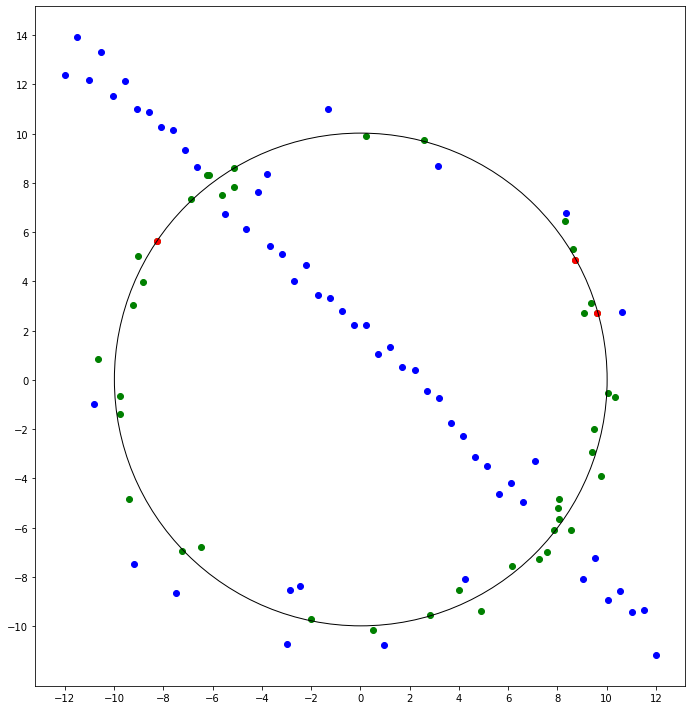

In [308]:

N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0,2*np.pi,half_n )
n = s*np.random.randn(half_n)
x,y = (r + n)*np.cos(t),(r+n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n,1),y.reshape(half_n,1)))
m,b = -1,2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack ( ( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_circ , X_line ) )


circ_RANSAC(X,N)



In [299]:
def circ_RANSAC(X,N):
    
    e = 0.5
    s = 3
    p = 0.99
    thresh = 0.7
    d = 10
    
    #iter_rounds = int(np.log(1-p)/np.log(1-(1-e)**s))
    iter_rounds = 1000
    best_samples = []
    best_inliers = []
    best_outliers = []
    best_errors = []
    best_inlier_counts=[]
    
    for i in range(iter_rounds):
        
        [x,y,z] = random.choices(X,k=3)
        circ_x, circ_y, radius = circle(x,y,z)
        inliers = []
        outliers = []
        
        if not (circ_x == False and circ_y == False and radius == False):
            a, b = radius - thresh, radius + thresh
            for point in X:
                point=list(point)
                if inRange(point,circ_x,circ_y,a,b):  
                    inliers.append(point)
                else:
                    outliers.append(point)
            
            if len(inliers) >= d:
                error = calError(inliers,circ_x,circ_y,radius)
                best_errors.append(error)
                best_samples.append([x,y,z])
                
                best_inliers.append(inliers)
                best_inlier_counts.append(len(inliers))
                best_outliers.append(outliers)
   
    best = max(best_inlier_counts)
    count = np.count_nonzero(best_inlier_counts == best)
    if count > 1:
        indexes = np.where(best_inlier_counts==best)
        e=[]
        for j in indexes:
            e.append(best_errors[j])
        k = best_errors.index(min(e))
    else:
        k = best_inlier_counts.index(best)
    best_dots = np.array(best_samples[k])
    inlier_dots = np.array(best_inliers[k])
    outlier_dots = np.array(best_outliers[k])
    
    a,b,c = circle(best_samples[k][0],best_samples[k][1],best_samples[k][2])
    fig,ax = plt.subplots(figsize=(12,12.5))
    ax.set_xticks([i for i in range(-12,13,2)])
    ax.set_yticks([i for i in range(-10,15,2)])
    
    # ax.scatter(X[:,0],X[:,1],color='b')
    
    ax.scatter(inlier_dots[:,0],inlier_dots[:,1],color='g')
    ax.scatter(outlier_dots[:,0],outlier_dots[:,1],color='b')
    ax.scatter(best_dots[:,0],best_dots[:,1],color='r')
    
    Drawing_uncolored_circle = plt.Circle( (a,b ),c ,fill = False )
    ax.set_aspect( 1 )
    ax.add_artist( Drawing_uncolored_circle )

    # ax.scatter(X_circ[:,0],X_circ[:,1],color='g')
    plt.show()

In [102]:
def calError(inliers,circ_x,circ_y,radius):
    sum_ = 0
    for point in inliers:
        sum_ += abs(np.sqrt((point[0]-circ_x)**2+(point[1]-circ_y)**2) - radius)
    return sum_/len(inliers)

In [73]:
def inRange(point,circ_x,circ_y,a,b): 
    return True if a <= np.sqrt((circ_x-point[0])**2 + (circ_y-point[1])**2) <= b else False

In [306]:
def circle(x,y,z):
    x = complex(x[0],x[1])
    y = complex(y[0],y[1])
    z = complex(z[0],z[1])
    try:
        w = z-x
        w /= y-x
        c = (x-y)*(w-abs(w)**2)/2j/w.imag-x
    except ZeroDivisionError:
        return False,False,False
    
    return (c.real, c.imag, abs(c+x)) #(-center_x,-center_y,r)
            

    

In [10]:
x, y, z = 0+1j, 1+0j, 0-1j
w = z-x
w /= y-x
c = (x-y)*(w-abs(w)**2)/2j/w.imag-x
print ('(x%+.3f)^2+(y%+.3f)^2 = %.3f^2' % (c.real, c.imag, abs(c+x)))

(x+0.000)^2+(y+0.000)^2 = 1.000^2


In [85]:
a = [[2,[4,5,6,2]],[56,[1,4,2,67,100]],[0,[2,2,89]],[0,[2,2,100,9]]]
print(min(a))

[0, [2, 2, 89]]
